In [2]:
# importing required libraries 

import pandas as pd
import numpy as np
# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# CountVectorizer for Bagof words model
from sklearn.feature_extraction.text import CountVectorizer

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

# MODEL1

In [3]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        
        # BOW 
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.review.tolist())
        
        # Creating Vocabulary
        self.token2idx = vectorizer.vocabulary_
        
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.review.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [4]:
data  = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data['label'] = data['sentiment']
del data['sentiment']
data.head()

,review,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
labeling = {'positive':1, 'negative':0}
data['label'] = data['label'].apply(lambda x : labeling[x])
data.shape

(50000, 2)

In [6]:
# feeding data in class and getting its instance in return 
dataset = Sequences(data, max_seq_len=128)
len(dataset.token2idx)

1046

In [7]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 2048
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

In [8]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cpu'
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self ):
        
        return (torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device),
                torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device) )
       
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        #o
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [9]:
model = RNN(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    batch_size=batch_size
)
model

RNN(
  (encoder): Embedding(1046, 100)
  (rnn): LSTM(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [11]:
model.train()
train_losses = []
for epoch in range(5):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs, target
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.691


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.617


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.532


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.477


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.426


In [12]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text))])
        
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [13]:
text= "that's nice"
predict_sentiment(text)

0.574: Positive sentiment


In [14]:
text = """I love this car.
This view is amazing.
I feel great this morning.
I am so excited about the concert.
He is my best friend
"""
predict_sentiment(text)

0.841: Positive sentiment


In [15]:
text="""
I do not like this car.
This view is horrible.
I feel tired this morning.
I am not looking forward to the concert.
He is my enemy
"""
predict_sentiment(text)

0.229: Negative sentiment


# MODEL2

In [16]:
data=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [17]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [18]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Generating word frequencies

In [19]:
def gen_freq(text):
    #will store all the words in list
    words_list = []
    
    #Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)
        
    #Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()
    
    #print top 100 words
    word_freq[:100]
    
    return word_freq  

In [20]:
freq = gen_freq(data.review.str)
freq

the                568735
a                  306960
and                301919
of                 283625
to                 261850
                    ...  
"Mithi/Mithali"         1
(Konkona)               1
"Prof.Anu"              1
(Shabhana               1
Yosemite.<br            1
Length: 438729, dtype: int64

# Word cloud

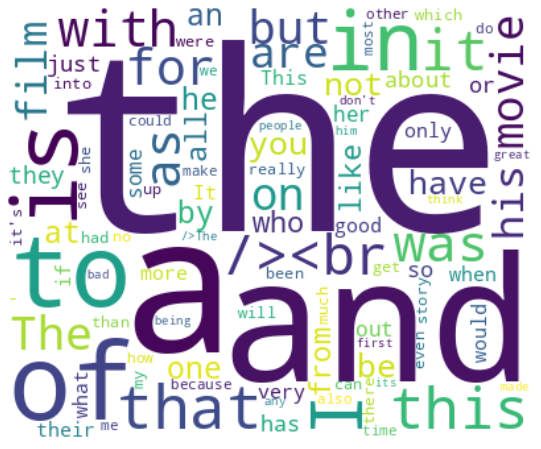

In [21]:
#Import library WordCloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Positive word cloud

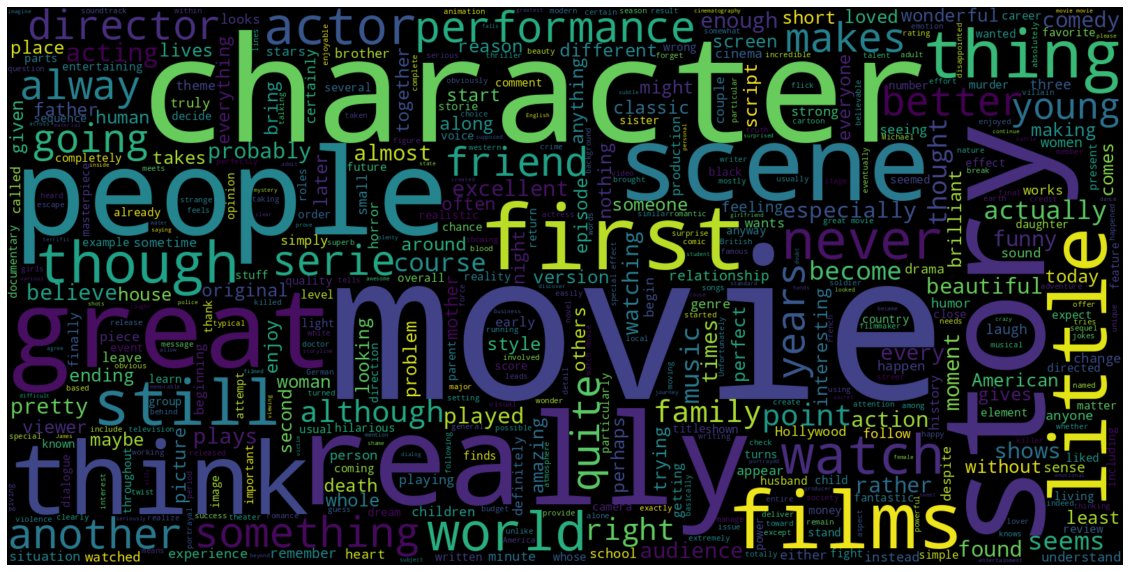

In [22]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.sentiment == 1].review))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Negative word cloud

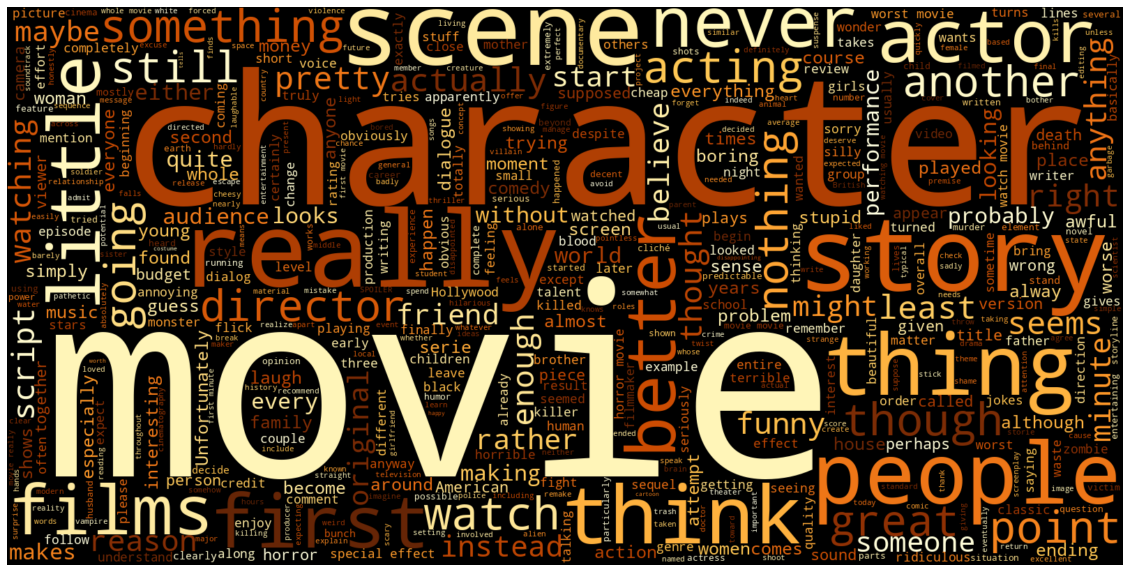

In [23]:
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.sentiment == 0].review))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# Removing stop words

In [24]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [25]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#Tokenization of text
tokenizer=ToktokTokenizer()

In [26]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
data['review']= data['review'].apply(remove_stopwords)

In [27]:
import re
#clearing punctuation & unnecessary marks
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
data['review'] = data['review'].apply(lambda x: x.lower())

#cleaning extra spaces
data['review'] = data['review'].apply(lambda x: x.strip())

# Removing html strips and noise text

In [28]:
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    return text

#Apply function on review column
    text = strip_html(text)
    text = remove_between_square_brackets(text)
data['review']=data['review'].apply(denoise_text)
data_copy = data.copy()

# Word clouds after text cleaning

In [29]:
data.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ...,1
1,wonderful little production br br the ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks ...,0
4,petter mattei love time money visually stu...,1


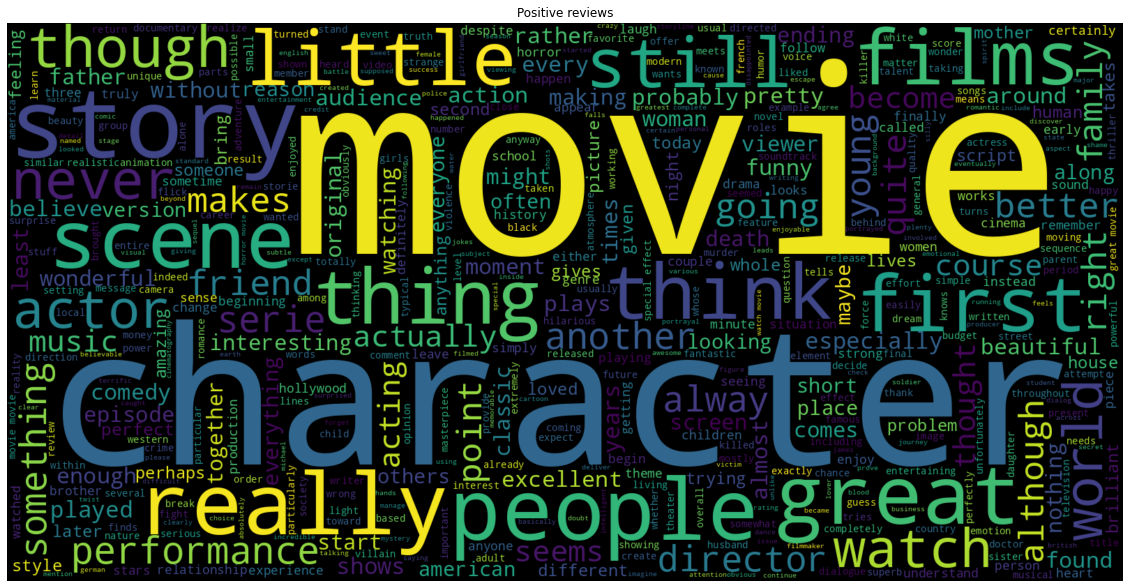

In [30]:
# POSITIVE REVIEWS
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.sentiment == 1].review))

plt.axis("off")
plt.title('Positive reviews')
plt.imshow(Wc , interpolation = 'bilinear')

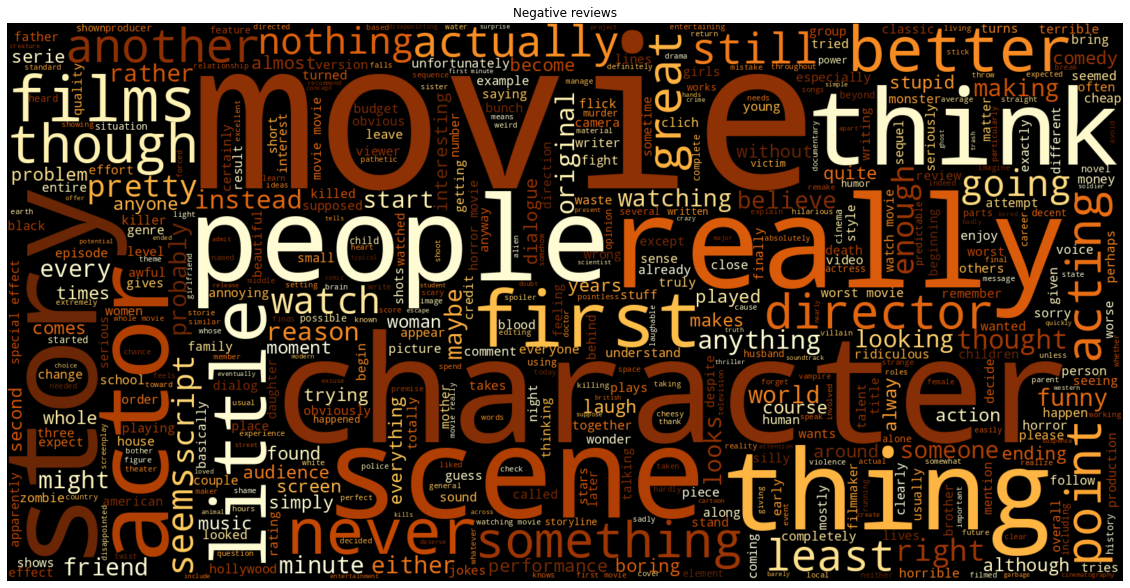

In [31]:
# Negative Reviews
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.sentiment == 0].review))

plt.axis("off")
plt.title('Negative reviews')
plt.imshow(Wc , interpolation = 'bilinear')

# Test-train split

In [32]:
sentiment = data['sentiment'].values
data = data['review']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

# Dictionary

In [33]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)
#tokenizer.word_index

# Bring the comments to the same size

In [34]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

# Replace the words in our sentences with whichever index they are included in the dictionary we have created above

In [35]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

292

In [36]:
#percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9454

In [37]:
import keras
#data is adjusted according to the number of tokens specified
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_tokens, maxlen=max_tokens)
x_train_pad.shape

(40000, 292)

In [38]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

# LSTM

In [39]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

2022-04-08 18:53:33.263025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 18:53:33.264254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 18:53:33.264932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 18:53:33.265768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 292, 50)           750000    
_________________________________________________________________
lstm (LSTM)                  (None, 292, 16)           4288      
_________________________________________________________________
dropout (Dropout)            (None, 292, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 292, 8)            800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 292, 8)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

In [41]:
history = model.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

2022-04-08 18:53:39.594981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-08 18:53:43.658981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


28/28 [==============================] - 9s 136ms/step - loss: 0.6829 - accuracy: 0.5872 - val_loss: 0.6459 - val_accuracy: 0.7252
Epoch 2/5
28/28 [==============================] - 3s 94ms/step - loss: 0.5315 - accuracy: 0.8015 - val_loss: 0.4671 - val_accuracy: 0.8302
Epoch 3/5
28/28 [==============================] - 3s 92ms/step - loss: 0.3827 - accuracy: 0.8767 - val_loss: 0.3879 - val_accuracy: 0.8514
Epoch 4/5
28/28 [==============================] - 3s 94ms/step - loss: 0.2963 - accuracy: 0.9173 - val_loss: 0.3693 - val_accuracy: 0.8567
Epoch 5/5
28/28 [==============================] - 3s 92ms/step - loss: 0.2423 - accuracy: 0.9409 - val_loss: 0.3632 - val_accuracy: 0.8612


In [42]:
result = model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 5s 13ms/step - loss: 0.3547 - accuracy: 0.8646


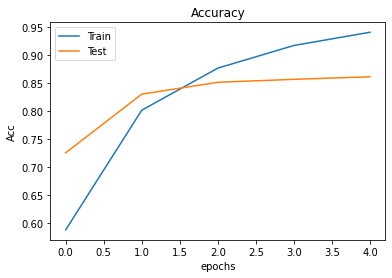

In [43]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

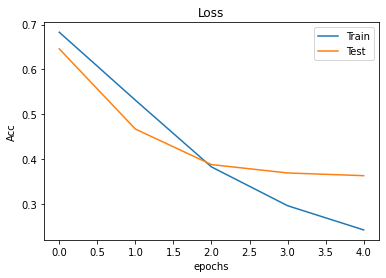

In [44]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [45]:
df=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df['sentiment'] = np.where(df['sentiment'] == 'positive', 1, 0)
df=pd.DataFrame(df['sentiment'])
df

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [46]:
pd.DataFrame(data)

,review
0,one reviewers mentioned watching oz episode ...
1,wonderful little production br br the ...
2,thought wonderful way spend time hot summer we...
3,basically family little boy jake thinks ...
4,petter mattei love time money visually stu...
...,...
49995,thought movie right good job creative origin...
49996,bad plot bad dialogue bad acting idiotic di...
49997,catholic taught parochial elementary schools n...
49998,going disagree previous comment side maltin on...


In [47]:
data.to_csv('Optimized.csv')

In [48]:
df=data
df.head()

0    one reviewers mentioned watching   oz episode ...
1    wonderful little production  br     br    the ...
2    thought wonderful way spend time hot summer we...
3    basically   family little boy  jake  thinks   ...
4    petter mattei    love time money  visually stu...
Name: review, dtype: object

In [49]:
data.columns = ['review', 'sentiment']
data.head()

0    one reviewers mentioned watching   oz episode ...
1    wonderful little production  br     br    the ...
2    thought wonderful way spend time hot summer we...
3    basically   family little boy  jake  thinks   ...
4    petter mattei    love time money  visually stu...
Name: review, dtype: object

# Load and Clean Dataset
Remove html tags, non alphabet (punctuations and numbers), stop words, and lower case all of the reviews.

In [51]:
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english')) #declaring stop words

def load_dataset():
    df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


# Test-train split

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
6001     [this, one, worst, movies, i, ever, seen, i, s...
46498    [ok, helicopter, shots, fantastic, director, m...
7549     [i, explain, far, trend, goes, ripping, asian,...
9259     [jeremy, irons, forrest, whitaker, good, actor...
40553    [i, saw, good, ago, cant, get, i, looked, ever...
                               ...                        
40086    [i, thought, movie, highly, underrated, the, s...
31425    [overall, i, found, movie, quite, amusing, fun...
28675    [ever, went, youtube, well, definite, question...
14987    [the, world, going, miss, john, frankenheimer,...
33923    [i, yet, watch, first, entry, series, however,...
Name: review, Length: 35000, dtype: object 

1075     [must, agree, reviewer, this, got, worst, movi...
1232     [i, sure, film, could, ever, match, first, one...
45776    [if, i, could, give, zero, i, change, mind, gi...
13377    [honestly, mr, thalluri, drama, movie, high, s...
20264    [i, barely, find, words, express, utterly, utt...
 

In [53]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

# Tokenize and Pad/Truncate Reviews

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[    8     5   160 ...     0     0     0]
 [  490  4070   561 ...     0     0     0]
 [    1  1155   135 ...     0     0     0]
 ...
 [   51   323  5878 ... 12873   353     7]
 [    2    85    81 ...     0     0     0]
 [    1   150    33 ...     0     0     0]] 

Encoded X Test
 [[  108   929  2074 ...     0     0     0]
 [    1   159     4 ...     0     0     0]
 [   54     1    27 ...     0     0     0]
 ...
 [   39  3057     4 ...     0     0     0]
 [  302   103   234 ...     4 82586 53614]
 [  421  2057  4188 ...     0     0     0]] 

Maximum review length:  130


# LSTM model

In [55]:
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint   
from tensorflow.keras.models import load_model
# LSTM Model
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           2806496   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,831,393
Trainable params: 2,831,393
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Final evaluation of the model

model.fit(x_train, y_train, batch_size = 256, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
137/137 [==============================] - 3s 11ms/step - loss: 0.5430 - accuracy: 0.6799

Epoch 00001: accuracy improved from -inf to 0.67991, saving model to models/LSTM.h5
Epoch 2/5
137/137 [==============================] - 2s 11ms/step - loss: 0.2452 - accuracy: 0.9113

Epoch 00002: accuracy improved from 0.67991 to 0.91131, saving model to models/LSTM.h5
Epoch 3/5
137/137 [==============================] - 2s 12ms/step - loss: 0.1409 - accuracy: 0.9573

Epoch 00003: accuracy improved from 0.91131 to 0.95734, saving model to models/LSTM.h5
Epoch 4/5
137/137 [==============================] - 2s 11ms/step - loss: 0.0889 - accuracy: 0.9758

Epoch 00004: accuracy improved from 0.95734 to 0.97580, saving model to models/LSTM.h5
Epoch 5/5
137/137 [==============================] - 2s 13ms/step - loss: 0.0587 - accuracy: 0.9855

Epoch 00005: accuracy improved from 0.97580 to 0.98549, saving model to models/LSTM.h5


In [57]:
y_pred = model.predict(x_test, batch_size = 128)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

Correct Prediction: 0
Wrong Prediction: 15000
Accuracy: 0.0


In [58]:
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import collections
import itertools

# Text cleaning

In [59]:
df=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))
df

,review,sentiment,review_cleaned
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is a...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...


# Baseline linear model
Tfidf method is used for text vectorization.

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6238
           1       0.89      0.91      0.90      6262

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



<AxesSubplot:>

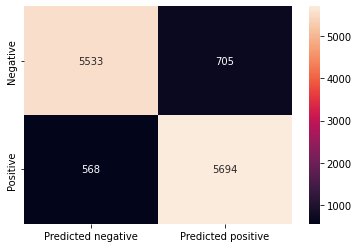

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'].map({'negative':0, 'positive':1}))
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# LSTM for 500 characters

In [61]:
df['review_cleaned_500'] = df['review_cleaned'].apply(lambda x:x[:500])

df['review_cleaned_500'][2]

'i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to love this was the most i d laugh'

# Tokenize and padding

In [62]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['review_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 116), X_min: 0, X_max: 9999


In [63]:
y = df['sentiment'].map({'negative' : 0, 'positive' : 1}).values

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(32000, 116) (8000, 116) (10000, 116) (32000,) (8000,) (10000,)


In [64]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [65]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1000/1000 [==============================] - 13s 10ms/step - loss: 0.4586 - accuracy: 0.7815 - val_loss: 0.3959 - val_accuracy: 0.8221
Epoch 2/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3204 - accuracy: 0.8674 - val_loss: 0.3845 - val_accuracy: 0.8338
Epoch 3/5
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2509 - accuracy: 0.8996 - val_loss: 0.4126 - val_accuracy: 0.8279
Epoch 4/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1893 - accuracy: 0.9266 - val_loss: 0.4668 - val_accuracy: 0.8213
Epoch 5/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1394 - accuracy: 0.9481 - val_loss: 0.6403 - val_accuracy: 0.8161


<AxesSubplot:>

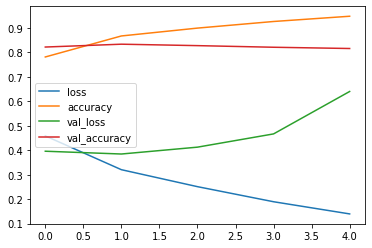

In [66]:
pd.DataFrame(history.history).plot()